# Simplest PCM analysis ever !

This notebook shows how to run a [Profile Classification Models (PCM)](https://pyxpcm.readthedocs.io/en/latest/overview.html) analysis on a specific rectangular ocean domain.

It is based on:
- [argopy](https://argopy.readthedocs.io/) to download Argo data
- [pyxpcm](https://pyxpcm.readthedocs.io/) to compute a PCM model

The only real technical difficult is in preparing the heterogeneous pressure levels Argo measurements for the PCM classifier. Indeed, using a PCM requires data to all be on the same 'depth' vertical axis. Hence we need to (i) interpolate all Argo profiles onto a standard pressure level axis and (ii) transform the vertical pressure axis in a depth axis.


In [1]:
import numpy as np
import xarray as xr
xr.set_options(display_style="html", display_expand_attrs=False);
import gsw

import argopy
# argopy.clear_cache()
argopy.status(refresh=5)

from pyxpcm.models import pcm

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/boundary_currents_pcm")
from pcmbc.utilities import from_misc_press_2_std_depth
from pcmbc.plot import Plotter

/Users/gmaze/miniconda3/envs/virtualfleet/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


HTML(value='<table><tr><td><img src="https://img.shields.io/static/v1?style=flat-square&label=src%20argovis%20…

# Define the rectangular domain to analyse

The box here should encompasses a larger area that the core of BC current, in order to show to the classifier enough profiles with different structures.

In [2]:
# [lon_min, lon_max, lat_min, lat_max]

# box = [-75.,-35.,35,50.]  # Gulf Stream Extension
# box = [-1., 5., 35., 42.]  # Western Mediterranean (Extended)
box = [-0.5, 5.6, 38.8, 41.4]  # Western Mediterranean
# box = [-10., -6., 32., 38.5]  # Gulf of Cadiz (Extended)
# box = [-20., 5. ,69., 77.]  # Nordic Seas (western part)
# box = [-20., 15. , 65., 77.]  # Nordic Seas (Extended)

# Load Argo data with argopy

In [3]:
data_box = box.copy()

# For argopy, we need a box like: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max]
data_box.append(0)   # Pres_min
data_box.append(500)# Pres_max

# We also give the domain definition some temporal bounds to limit the amount of data to download
# (this is just for demonstration purposes)
data_box.append('2018-01-01')
data_box.append('2022-01-01')

# Finaly define the data fetcher:
# ('argovis' is well suited for large dataset, use 'erddap' or 'gdac' for more advanced use cases)
argo = argopy.DataFetcher(src='erddap', cache=True, parallel=True, progress=True).region(data_box)
argo

<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://www.ifremer.fr/erddap
Domain: [x=-0.50/5.60; y=38.80/41.40;  ... 00.0; t=2018-01-01/2022-01-01]
Performances: cache=True, parallel=True
User mode: standard
Dataset: phy

In [4]:
# Before downloading the data, make sure it will be of reasonable size for memory !
index = argopy.IndexFetcher(src='gdac', cache=True).region([data_box[i] for i in [0,1,2,3,6,7]]).load()
print("%i max profiles reported for your data selection" % index.fetcher.N_FILES)
if index.fetcher.N_FILES > 5e3:
    print("""\n OH OH !\nYou have a significant amount of profiles to load, depending 
          on your data-source this may take a while or fail, or succeed ! Be warned !""")

1800 max profiles reported for your data selection


In [5]:
%%time
# Load data:
ds = argo.load().data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:01<00:00,  3.61s/it]


CPU times: user 20.5 s, sys: 1.72 s, total: 22.2 s
Wall time: 1min 15s


In [6]:
%%time
# Transform the collection of points in a collection of profiles:
dsp = ds.argo.point2profile()
dsp['N_PROF'] = np.arange(dsp['N_PROF'].max()+1)
dsp

CPU times: user 7.87 s, sys: 54.2 ms, total: 7.92 s
Wall time: 7.84 s


<xarray.Dataset>
Dimensions:                (N_PROF: 1402, N_LEVELS: 496)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 1 2 3 4 ... 1397 1398 1399 1400 1401
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 ... 491 492 493 494 495
    LATITUDE               (N_PROF) float64 40.88 40.03 40.85 ... 39.02 39.12
    LONGITUDE              (N_PROF) float64 3.436 2.487 3.777 ... 1.947 1.108
    TIME                   (N_PROF) datetime64[ns] 2018-06-22T05:47:00 ... 20...
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 3 2 4 2 4 4 2 4 4 ... 2 2 2 8 2 2 2 2
    CYCLE_NUMBER           (N_PROF) int32 101 91 102 92 103 ... 407 41 101 4 4
    DATA_MODE              (N_PROF) <U1 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 6901249 6902773 ... 6901282 6901283
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float32 38.18 38.19 ... nan nan
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float32 22.66 22.61 ... nan nan
    TEMP_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes: (8)

In [7]:
# Here you could save the Argo dataset for later re-use
# dsp.to_netcdf('sample_argoset.nc')  # Save
# dsp = xr.open_dataset('sample_argoset.nc')  # Reload

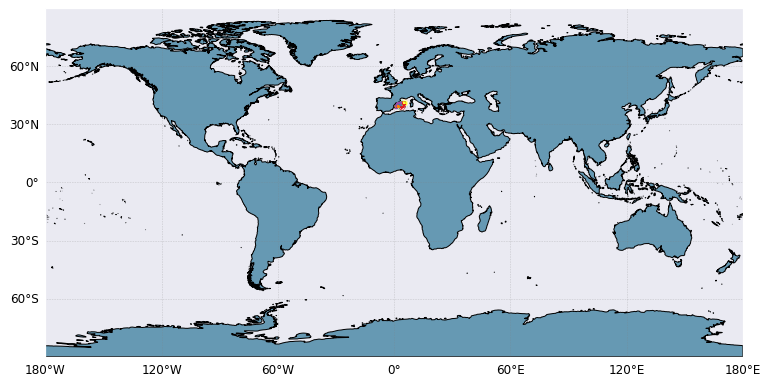

In [8]:
# Have a quick look to the dataset distribution in space:
argo.plot('trajectory', set_global=True);

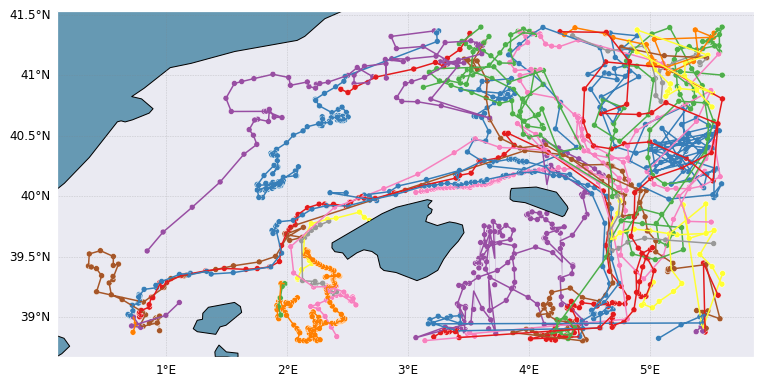

In [9]:
# Have a quick look to the dataset distribution in space:
argo.plot('trajectory');

# Classify profiles (fit a PCM and make predictions, i.e. classification)

## Prepare data for classification

### Classifier

In [10]:
# Define variables to be used by classifier:

# a vertical depth axis:
# (must be negative and oriented downard)
# pcm_dpt_axis = np.arange(0.,-1400,-10.)   # Looks good for GS, Nordic Seas
pcm_dpt_axis = np.arange(0.,-450,-10.)  # Looks good for Western Med.
# pcm_dpt_axis = np.arange(-50.,-250,-5.)  # Looks good for Gulf of Cadiz

# and measurements:
# pcm_features = {'temperature': pcm_dpt_axis}
# pcm_features = {'salinity': pcm_dpt_axis}
pcm_features = {'temperature': pcm_dpt_axis, 'salinity': pcm_dpt_axis}

# The above means that we're using the [0/z]m T/S data to automatically classify profiles

In [11]:
# Init a PCM classifier, here with k=3 classes:
# m = pcm(K=4, features=pcm_features)
m = pcm(K=3, features=pcm_features, timeit=True, timeit_verb=0)
m

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Training set from Argo profiles

In [12]:
# dsi = from_misc_press_2_std_depth(m, dsp)
dsi = from_misc_press_2_std_depth(m, dsp, feature_name='salinity')
dsi

<xarray.Dataset>
Dimensions:                (N_PROF: 819, DEPTH_INTERPOLATED: 46)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 1 2 3 4 5 ... 814 815 816 817 818
    LATITUDE               (N_PROF) float64 38.84 38.92 39.01 ... 39.02 39.12
    LONGITUDE              (N_PROF) float64 2.41 2.365 2.313 ... 1.947 1.108
    TIME                   (N_PROF) datetime64[ns] 2018-08-30T23:55:00 ... 20...
  * DEPTH_INTERPOLATED     (DEPTH_INTERPOLATED) float64 -0.0 -9.924 ... -485.7
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 2 3 2 3 2 3 2 3 2 ... 2 2 2 2 8 2 2 2
    CYCLE_NUMBER           (N_PROF) int32 314 315 316 317 318 ... 187 407 41 4 4
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'R' 'R' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 6901839 6901839 ... 6901282 6901283
    PRES                   (N_PROF, DEPTH_INTERPOLATED) float32 6.1 ... 490.0
    PSAL                   (N_PROF, DEPTH_INTERPOLATED) float32 37.84 ... 38.58
    TEMP                   (N_PROF, DEPTH_INTERPOLATED) float32 27.59 ... 13.47
Attributes: (8)

### Quick look to the "training set"

No worries for NaNs, these are handled by the pyXpcm librairy

But be careful with outliers ! PCM will tend to attribute an entire class to a specific outlier, messing up the analysis

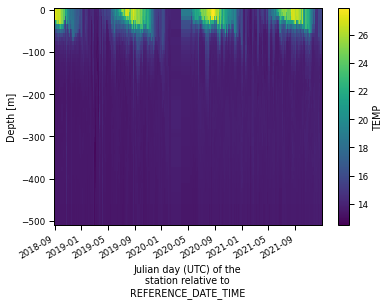

In [13]:
dsi.sortby('TIME')['TEMP'].plot(x='TIME')

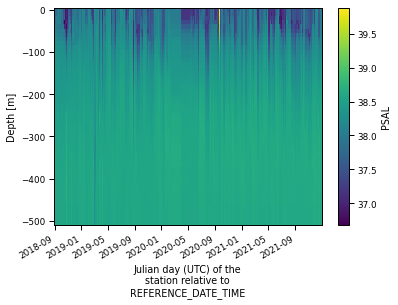

In [14]:
dsi.sortby('TIME')['PSAL'].plot(x='TIME')

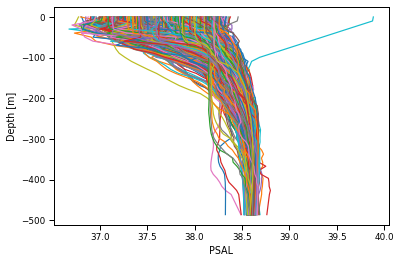

In [15]:
dsi.sortby('TIME')['PSAL'].plot(y='DEPTH_INTERPOLATED', hue='TIME', add_legend=False);

## Compute parameters of the PCM

This is the un-supervised fit of the classifier parameters on input data

In [16]:
%%time

# Tells PCM where to find data on the training set "dsi":
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_zdim = 'DEPTH_INTERPOLATED'

# Make the fit:
m.fit(dsi, features=features_in_ds, dim=features_zdim)
m

CPU times: user 2.73 s, sys: 182 ms, total: 2.91 s
Wall time: 463 ms


<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 0.823378

## Compute classification results (labels, probabilities)

i.e. apply the PCM classifier to the training set

In [17]:
# Predict labels and proba:
m.predict(dsi, features=features_in_ds, dim=features_zdim, inplace = True)
m.predict_proba(dsi, features=features_in_ds, dim=features_zdim, inplace = True)

# Compute robustness:
dsi.pyxpcm.robustness(m, inplace = True)
dsi.pyxpcm.robustness_digit(m, inplace = True)

# and further compute the "typical" profiles of each classes, using quantiles of profiles:
for vname in ['TEMP', 'PSAL']:
    dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

# Visualize results

## Simplest figures

### Typical profiles of each classes

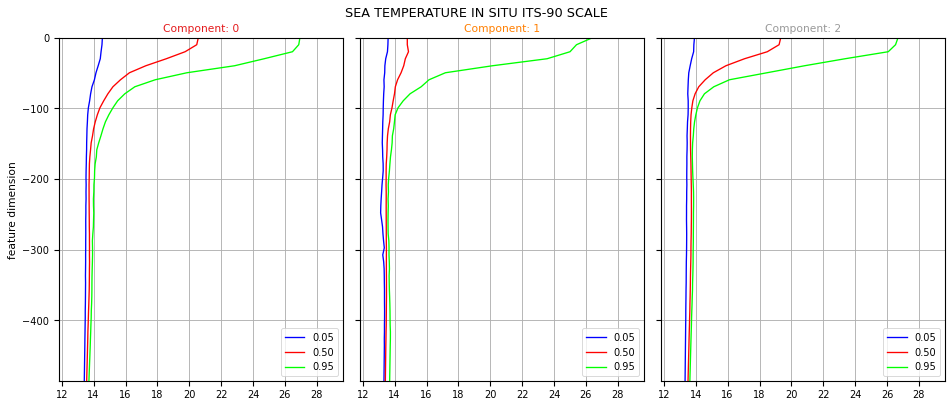

In [18]:
fig, ax = m.plot.quantile(dsi['TEMP_Q'], maxcols=4, figsize=(12, 5), sharey=True)
fig.suptitle(dsp['TEMP'].attrs['long_name'], verticalalignment='bottom');

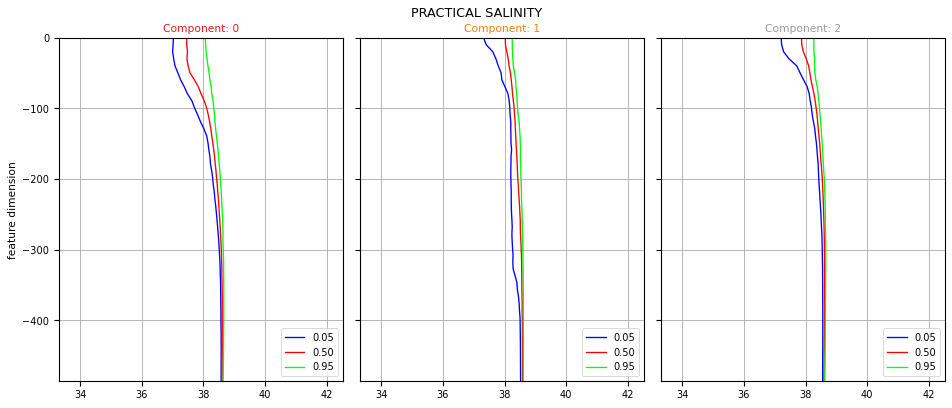

In [19]:
fig, ax = m.plot.quantile(dsi['PSAL_Q'], maxcols=4, figsize=(12, 5), sharex=True, sharey=True)
# ax[0].set_xlim([34, 36])
# ax[0].set_xlim([35, 37])
fig.suptitle(dsp['PSAL'].attrs['long_name'], verticalalignment='bottom');

### Spatial distribution of profiles colored by the class/label they've been attributed to

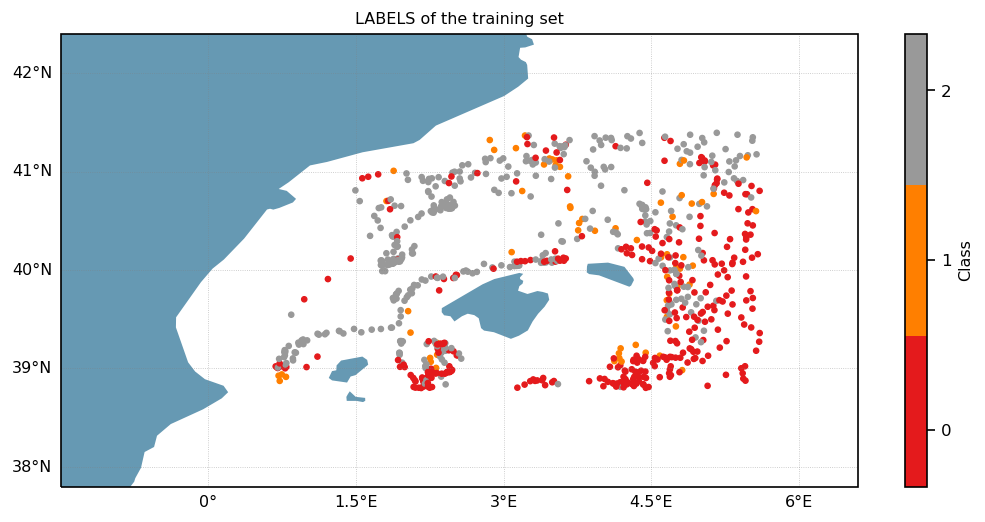

In [30]:
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
dx, dy = 1, 1  # How much to extent the map contours wrt to the data set real domain
subplot_kw={'projection': proj, 'extent': np.array(box) + np.array([-dx,+dx,-dy,+dy])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cname = 'Set1'
sc = ax.scatter(dsi['LONGITUDE'], dsi['LATITUDE'], s=10, c=dsi['PCM_LABELS'], cmap=m.plot.cmap(name=cname), transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax, name=cname)
argopy.plot.utils.latlongrid(ax)
ax.add_feature(argopy.plot.utils.land_feature)
ax.set_title('LABELS of the training set')
plt.show()

## More figures with helper class

(<Figure size 800x400 with 3 Axes>,
 array([<AxesSubplot:title={'center':'quantile: 0.05'}, xlabel='PRACTICAL SALINITY', ylabel='depth (m)'>,
        <AxesSubplot:title={'center':'quantile: 0.50'}>,
        <AxesSubplot:title={'center':'quantile: 0.95'}>], dtype=object))

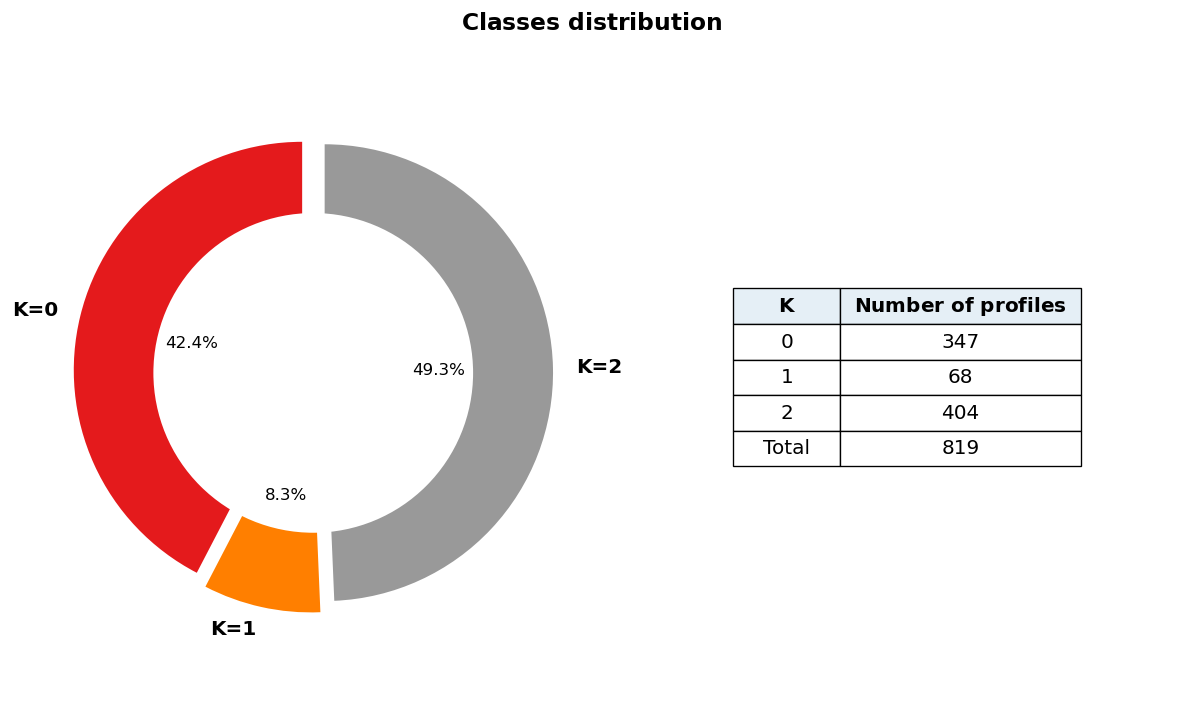

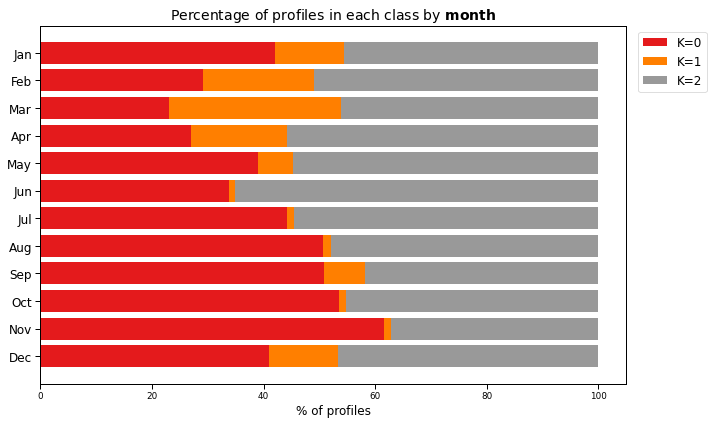

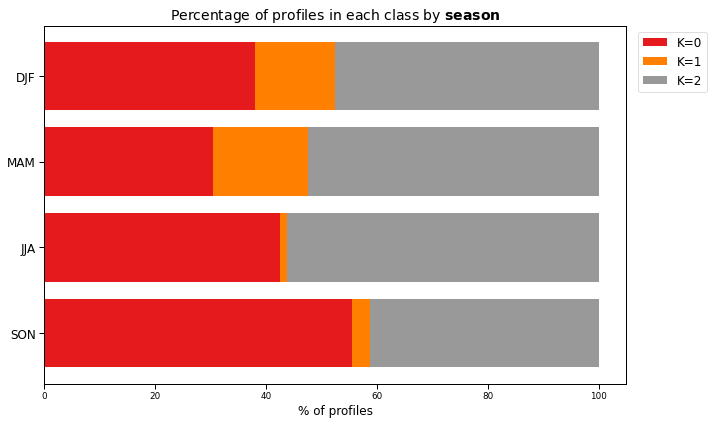

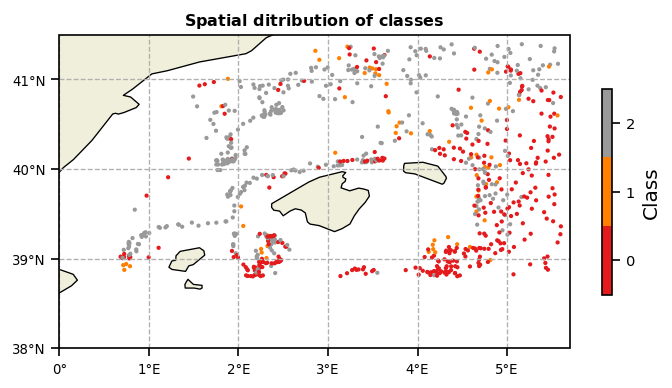

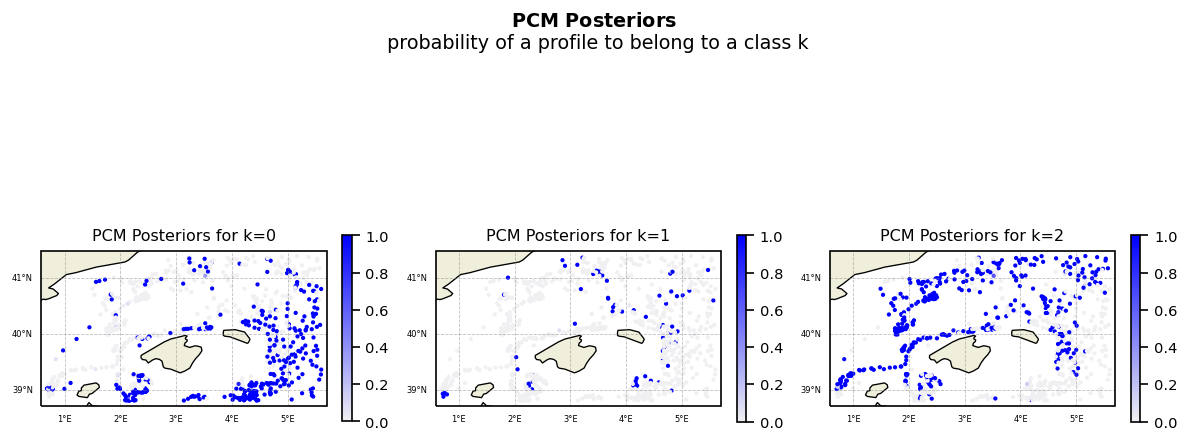

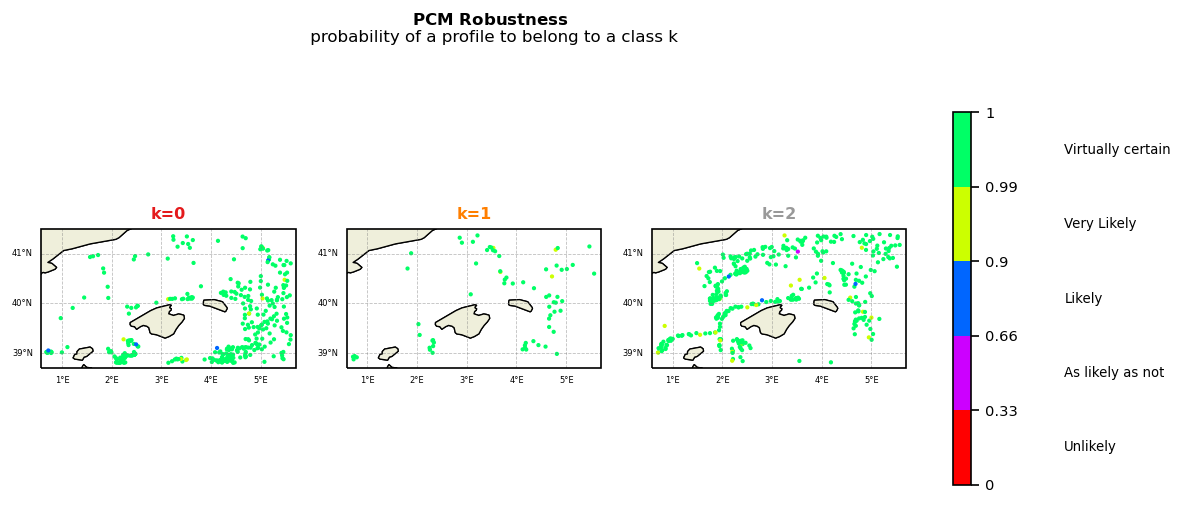

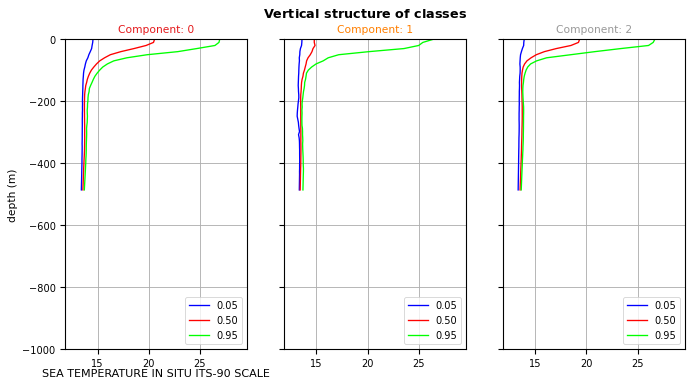

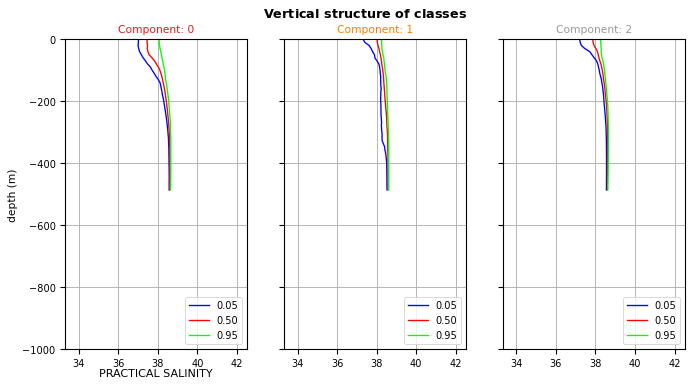

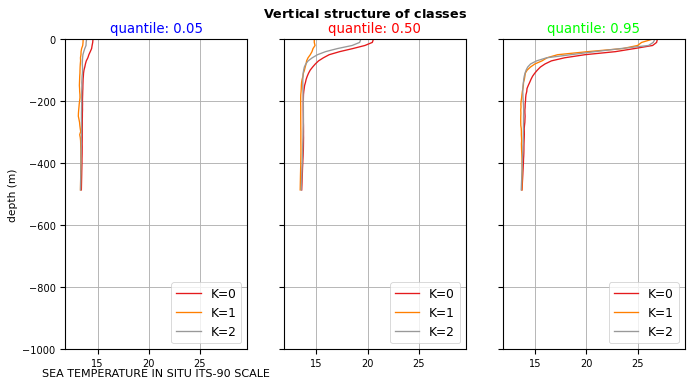

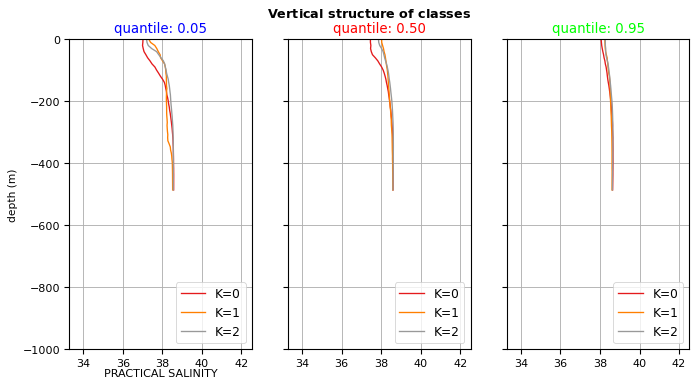

In [21]:
P = Plotter(dsi, m, coords_dict={'latitude': 'LATITUDE', 'longitude': 'LONGITUDE', 'time': 'TIME', 'depth': 'DEPTH_INTERPOLATED'}, cmap_name=cname)
P.pie_classes()
P.temporal_distribution(time_bins='month')
P.temporal_distribution(time_bins='season')
P.spatial_distribution(lon_grid=1, lat_grid=1)
P.plot_posteriors(lon_grid=1, lat_grid=1, figsize=(10,5))
P.plot_robustness(lon_grid=1, lat_grid=1, figsize=(10,5))
P.vertical_structure(q_variable='TEMP_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['TEMP'].attrs['long_name'])
P.vertical_structure(q_variable='PSAL_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['PSAL'].attrs['long_name'])
P.vertical_structure_comp(q_variable='TEMP_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['TEMP'].attrs['long_name'])
P.vertical_structure_comp(q_variable='PSAL_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['PSAL'].attrs['long_name'])

***

# What's next ?

- If you're happy with a given PCM, [you can save it](https://pyxpcm.readthedocs.io/en/latest/io.html#Saving-a-model) and later [load it from elsewhere](https://pyxpcm.readthedocs.io/en/latest/io.html#Loading-a-model) to classify new profiles

- If you're not happy with your PCM, you can: 
    - try to change the vertical depth axis or the variables used by the model. It could make more sense to go deeper, shallower or to use only temperature or only salinity to differentiate the various flavor of profiles in your training set. 
    - It is also possible that the classifier identifies seasonality in classes instead of different core vertical structures. In this case, use a temporal/seasonal subset of profiles to 'force' the PCM to focus on spatial variance, instead of the temporal one. You can also increase the number of classes so that you would have one class per season and category of profiles.
    - Run a BIC analysis to get an indication of how much classes to uses.

- In all cases, they are other interesting variables to look at: like the 'robustness' of the classification, or the probability of each profile to belong to a given class. This could further help you analyse the classification results. 

## Eg of saving the PCM model

In [22]:
m.to_netcdf('my_pcm.nc', global_attributes={'project': 'EARISE'})
# This netcdf file is complex and not meant to be open directly, instead use the pyxpcm.load_netcdf function (see below)

## Eg of loading a model and classifying a new dataset

In [23]:
# Import existing model:
import pyxpcm
m_loaded = pyxpcm.load_netcdf('my_pcm.nc')
m_loaded

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 0.823378

In [24]:
# Load new profiles to be classified:
# (as an example, here we load data from one of the floats used previously)
WMO = np.min(dsi['PLATFORM_NUMBER'].values)
a_float = argopy.DataFetcher(src='gdac', cache=True).float(WMO).load()
dsp_float = a_float.data.argo.point2profile()
dsp_float

<xarray.Dataset>
Dimensions:                (N_PROF: 432, N_LEVELS: 163)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 1 2 3 4 5 ... 427 428 429 430 431
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 ... 158 159 160 161 162
    TIME                   (N_PROF) datetime64[ns] 2016-06-05T12:53:00 ... 20...
    LATITUDE               (N_PROF) float64 39.26 39.28 39.21 ... 39.85 39.62
    LONGITUDE              (N_PROF) float64 10.77 10.7 10.46 ... 1.293 1.068
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 1 2 3 2 3 4 5 4 ... 9 8 9 8 9 8 9 8
    CYCLE_NUMBER           (N_PROF) int32 1 1 2 3 4 5 ... 429 430 431 432 433
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_PROF) <U1 'D' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 3901849 3901849 ... 3901849 3901849
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float64 38.18 38.18 ... nan nan
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float64 20.49 20.03 ... nan nan
    TEMP_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes: (8)

In [25]:
dsi_float = from_misc_press_2_std_depth(m_loaded, dsp_float, feature_name='salinity')
dsi_float

<xarray.Dataset>
Dimensions:                (N_PROF: 420, DEPTH_INTERPOLATED: 46)
Coordinates:
  * N_PROF                 (N_PROF) int64 0 1 2 3 4 5 ... 415 416 417 418 419
    TIME                   (N_PROF) datetime64[ns] 2016-06-06T11:57:00 ... 20...
    LATITUDE               (N_PROF) float64 39.28 39.21 39.02 ... 39.85 39.62
    LONGITUDE              (N_PROF) float64 10.7 10.46 10.31 ... 1.293 1.068
  * DEPTH_INTERPOLATED     (DEPTH_INTERPOLATED) float64 -0.0 -9.924 ... -485.7
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 2 3 2 3 4 5 4 5 ... 9 8 9 8 9 8 9 8
    CYCLE_NUMBER           (N_PROF) int32 1 2 3 4 5 6 ... 429 430 431 432 433
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 3901849 3901849 ... 3901849 3901849
    PRES                   (N_PROF, DEPTH_INTERPOLATED) float64 3.5 ... 490.0
    PSAL                   (N_PROF, DEPTH_INTERPOLATED) float64 38.2 ... 38.62
    TEMP                   (N_PROF, DEPTH_INTERPOLATED) float64 20.87 ... 13.81
Attributes: (8)

In [34]:
# and classify these "new" profiles:
m_loaded.predict(dsi_float, features={'temperature': 'TEMP', 'salinity': 'PSAL'}, dim='DEPTH_INTERPOLATED', inplace = True)
m_loaded.predict_proba(dsi_float, features={'temperature': 'TEMP', 'salinity': 'PSAL'}, dim='DEPTH_INTERPOLATED', inplace = True)
dsi_float.pyxpcm.robustness(m_loaded, inplace = True)
dsi_float.pyxpcm.robustness_digit(m_loaded, inplace = True)

dsi_float['PCM_LABELS']

/Users/gmaze/miniconda3/envs/virtualfleet/lib/python3.8/site-packages/pyxpcm/xarray.py:89: UserWarning: PCM_LABELS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/Users/gmaze/miniconda3/envs/virtualfleet/lib/python3.8/site-packages/pyxpcm/xarray.py:89: UserWarning: PCM_POST variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


<xarray.DataArray 'PCM_LABELS' (N_PROF: 420)>
array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2,
       0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 1])
Coordinates:
  * N_PROF     (N_PROF) int64 0 1 2 3 4 5 6 7 ... 413 414 415 416 417 418 419
    TIME       (N_PROF) datetime64[ns] 2016-06-06T11:57:00 ... 2022-05-06T11:...
    LATITUDE   (N_PROF) float64 39.28 39.21 39.02 38.94 ... 40.03 39.85 39.62
    LONGITUDE  (N_PROF) float64 10.7 10.46 10.31 10.15 ... 1.276 1.293 1.068
Attributes: (6)

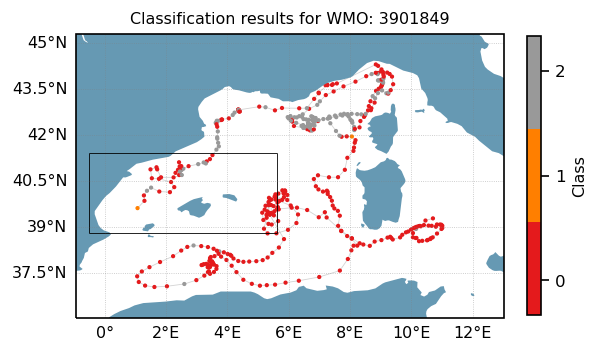

In [54]:
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
dx, dy = 2, 1  # How much to extend the map contours wrt to the data set real domain
subplot_kw={'projection': proj, 'extent': a_float.domain[0:4] + np.array([-dx,+dx,-dy,+dy])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.plot(dsi_float['LONGITUDE'], dsi_float['LATITUDE'], color='lightgray', linewidth=0.5, transform=proj, zorder=0)
sc = ax.scatter(dsi_float['LONGITUDE'], dsi_float['LATITUDE'], s=3, c=dsi_float['PCM_LABELS'], cmap=m_loaded.plot.cmap(name=cname), transform=proj, vmin=0, vmax=m_loaded.K)
cl = m_loaded.plot.colorbar(ax=ax, name=cname)
argopy.plot.utils.latlongrid(ax)
ax.hlines(box[2:4], box[0], box[1], 'k', linewidth=0.5)
ax.vlines(box[0:2], box[2], box[3], 'k', linewidth=0.5)
ax.add_feature(argopy.plot.utils.land_feature)
ax.set_title('Classification results for WMO: %s' % WMO)
plt.show()

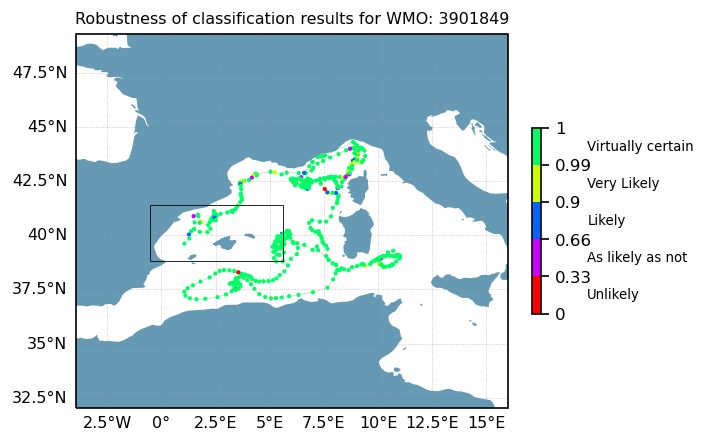

In [52]:
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
dx, dy = 5, 5  # How much to extend the map contours wrt to the data set real domain
subplot_kw={'projection': proj, 'extent': a_float.domain[0:4] + np.array([-dx,+dx,-dy,+dy])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.plot(dsi_float['LONGITUDE'], dsi_float['LATITUDE'], color='lightgray', linewidth=0.5, transform=proj, zorder=0)
sc = ax.scatter(dsi_float['LONGITUDE'], dsi_float['LATITUDE'], s=3, c=dsi_float['PCM_ROBUSTNESS_CAT'], cmap=m_loaded.plot.cmap(usage='robustness'), transform=proj)

rowl0 = dsi_float['PCM_ROBUSTNESS_CAT'].attrs['legend']
cl = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
cl.set_ticks([0, 1, 2, 3, 4, 5])
cl.set_ticklabels(dsi_float['PCM_ROBUSTNESS_CAT'].attrs['bins'])
for (i, j) in zip(np.arange(0.5, 5, 1), rowl0):
    cl.ax.text(6, i, j, ha='left', va='center', fontsize=8)

ax.hlines(box[2:4], box[0], box[1], 'k', linewidth=0.5)
ax.vlines(box[0:2], box[2], box[3], 'k', linewidth=0.5)
argopy.plot.utils.latlongrid(ax)
ax.add_feature(argopy.plot.utils.land_feature)
ax.set_title('Robustness of classification results for WMO: %s' % WMO)
plt.show()

In [48]:
box

[-0.5, 5.6, 38.8, 41.4]

# Troubles shooting

- the most common weird thing is to see a classification that is different between several run of the notebook (or fit). In this case:
    - make sure that this is not just a class color issue (the ordering of the class ID is random and not necessarily always the same, but this does not mean that classes are not the same)
    - if classes are realy different on every fit, this probably means that you do not use enough classes
    
- if one of your class vertical structure is flat, this probably means that PCM has identifies an outlier in the training dataset and has attributed a specific class for it. Try to remove the outlier.
    
- Benchmark of the different internal operation conducted by the PCM:

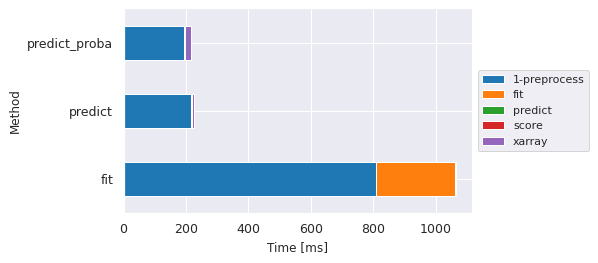

In [28]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split    

***
This notebook has been developed within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<a href="https://www.euro-argo.eu/EU-Projects/Euro-Argo-RISE-2019-2022">
<img src="https://user-images.githubusercontent.com/59824937/146353317-56b3e70e-aed9-40e0-9212-3393d2e0ddd9.png" width="75"/>
</a>
